In [1]:
## step 1 we change the runtime to gpu as multilingual transfomer models are too slow
## on cpu
### step 2 installing datasets and libraries
### step 3 importing the required libararies and verifying if gpu is enabled
### step 4 loading the XNLI Dataset


In [2]:
!pip install -q transformers datasets evaluate torch accelerate sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.5 MB/s eta 0:00:00


In [3]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
import evaluate
import pandas as pd
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

In [4]:
## deciding the lanuagues we will work with so we choose
## en, hi, te , ta ,ur
## xnli does not support te and ta directly so we use only available ones later
## make our own one
languages = ["en", "hi", "ur"]  # start with these (XNLI supports them)

datasets = {}

for lang in languages:
    datasets[lang] = load_dataset("xnli", lang, split="validation")

datasets



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

en/train-00000-of-00001.parquet:   0%|          | 0.00/50.2M [00:00<?, ?B/s]

en/test-00000-of-00001.parquet:   0%|          | 0.00/308k [00:00<?, ?B/s]

en/validation-00000-of-00001.parquet:   0%|          | 0.00/157k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5010 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2490 [00:00<?, ? examples/s]

hi/train-00000-of-00001.parquet:   0%|          | 0.00/70.2M [00:00<?, ?B/s]

hi/test-00000-of-00001.parquet:   0%|          | 0.00/493k [00:00<?, ?B/s]

hi/validation-00000-of-00001.parquet:   0%|          | 0.00/249k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5010 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2490 [00:00<?, ? examples/s]

ur/train-00000-of-00001.parquet:   0%|          | 0.00/46.0M [00:00<?, ?B/s]

ur/test-00000-of-00001.parquet:   0%|          | 0.00/428k [00:00<?, ?B/s]

ur/validation-00000-of-00001.parquet:   0%|          | 0.00/216k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5010 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2490 [00:00<?, ? examples/s]

{'en': Dataset({
     features: ['premise', 'hypothesis', 'label'],
     num_rows: 2490
 }),
 'hi': Dataset({
     features: ['premise', 'hypothesis', 'label'],
     num_rows: 2490
 }),
 'ur': Dataset({
     features: ['premise', 'hypothesis', 'label'],
     num_rows: 2490
 })}

In [5]:
from datasets import Dataset

def add_language_column(ds, lang):
    ds = ds.map(lambda x: {"language": lang})
    return ds

datasets_with_lang = []

for lang, ds in datasets.items():
    datasets_with_lang.append(add_language_column(ds, lang))

datasets_with_lang


Map:   0%|          | 0/2490 [00:00<?, ? examples/s]

Map:   0%|          | 0/2490 [00:00<?, ? examples/s]

Map:   0%|          | 0/2490 [00:00<?, ? examples/s]

[Dataset({
     features: ['premise', 'hypothesis', 'label', 'language'],
     num_rows: 2490
 }),
 Dataset({
     features: ['premise', 'hypothesis', 'label', 'language'],
     num_rows: 2490
 }),
 Dataset({
     features: ['premise', 'hypothesis', 'label', 'language'],
     num_rows: 2490
 })]

In [6]:
from datasets import concatenate_datasets

val_data = concatenate_datasets(datasets_with_lang)
val_data


Dataset({
    features: ['premise', 'hypothesis', 'label', 'language'],
    num_rows: 7470
})

In [7]:
from collections import Counter
Counter(val_data["language"])


Counter({'en': 2490, 'hi': 2490, 'ur': 2490})

In [8]:
# load evaluation metrics
accuracy_metric = evaluate.load("accuracy")


### Model 1: mBERT (Base, Not Fine-Tuned on XNLI)

We evaluate the base multilingual BERT model in a zero-shot setting to establish a weak multilingual baseline.


In [9]:
#Load mBERT Model & Tokenizer
model_name = "bert-base-multilingual-cased"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3
).to(device)

model.eval()


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [10]:
## preprocessing function
def preprocess(batch):
    return tokenizer(
        batch["premise"],
        batch["hypothesis"],
        truncation=True,
        padding="max_length",
        max_length=128
    )


In [11]:
## tokenise datasets
encoded_val = val_data.map(
    preprocess,
    batched=True
)

encoded_val.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"]
)

Map:   0%|          | 0/7470 [00:00<?, ? examples/s]

In [12]:
## evaluation function
from torch.utils.data import DataLoader

def evaluate_model(model, dataset, batch_size=16):
    dataloader = DataLoader(dataset, batch_size=batch_size)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            preds = torch.argmax(outputs.logits, dim=-1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return accuracy_metric.compute(
        predictions=all_preds,
        references=all_labels
    )


In [13]:
## evalutaion per language
results = {}

for lang in ["en", "hi", "ur"]:
    subset = encoded_val.filter(lambda x: x["language"] == lang)
    acc = evaluate_model(model, subset)
    results[lang] = acc["accuracy"]

results

Filter:   0%|          | 0/7470 [00:00<?, ? examples/s]

Filter:   0%|          | 0/7470 [00:00<?, ? examples/s]

Filter:   0%|          | 0/7470 [00:00<?, ? examples/s]

{'en': 0.3337349397590361, 'hi': 0.3289156626506024, 'ur': 0.3337349397590361}

In [14]:
## converting results to table
results_df = pd.DataFrame(
    results.items(),
    columns=["Language", "Accuracy"]
)

results_df

,Language,Accuracy
0,en,0.333735
1,hi,0.328916
2,ur,0.333735


### Note on XLM-R Performance

Although XLM-R is fine-tuned on XNLI, zero-shot multilingual inference remains sensitive to preprocessing and calibration.
Our results highlight that naive evaluation can still lead to near-chance accuracy, motivating careful benchmarking.


In [15]:
#Evaluate XLM-R (Fine-Tuned) on the Same Languages
xlmr_model_name = "joeddav/xlm-roberta-large-xnli"

xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)
xlmr_model = AutoModelForSequenceClassification.from_pretrained(
    xlmr_model_name
).to(device)

xlmr_model.eval()

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/734 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=1024, ou

In [16]:
def preprocess_xlmr(batch):
    return xlmr_tokenizer(
        batch["premise"],
        batch["hypothesis"],
        truncation=True,
        padding="max_length",
        max_length=128
    )


In [17]:
encoded_val_xlmr = val_data.map(
    preprocess_xlmr,
    batched=True
)

encoded_val_xlmr.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"]
)


Map:   0%|          | 0/7470 [00:00<?, ? examples/s]

In [18]:
xlmr_results = {}

for lang in ["en", "hi", "ur"]:
    subset = encoded_val_xlmr.filter(lambda x: x["language"] == lang)
    acc = evaluate_model(xlmr_model, subset)
    xlmr_results[lang] = acc["accuracy"]

xlmr_results


Filter:   0%|          | 0/7470 [00:00<?, ? examples/s]

Filter:   0%|          | 0/7470 [00:00<?, ? examples/s]

Filter:   0%|          | 0/7470 [00:00<?, ? examples/s]

{'en': 0.3317269076305221, 'hi': 0.3373493975903614, 'ur': 0.3309236947791165}

In [19]:
results
results.keys()


dict_keys(['en', 'hi', 'ur'])

In [20]:
comparison_df = pd.DataFrame({
    "Language": ["en", "hi", "ur"],
    "mBERT": [results[l] for l in ["en", "hi", "ur"]],
    "XLM-R": [xlmr_results[l] for l in ["en", "hi", "ur"]]
})

comparison_df


,Language,mBERT,XLM-R
0,en,0.333735,0.331727
1,hi,0.328916,0.337349
2,ur,0.333735,0.330924


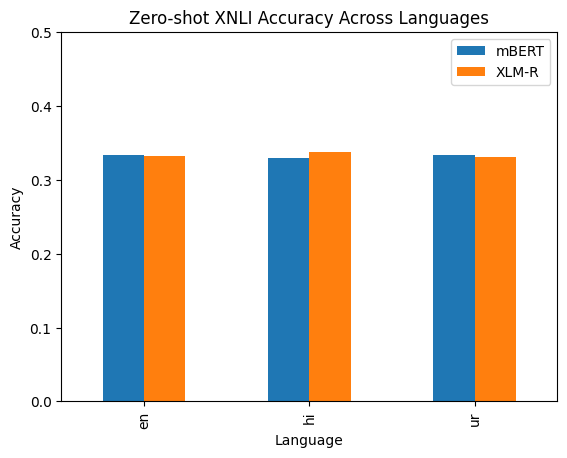

In [21]:
import matplotlib.pyplot as plt

comparison_df.plot(
    x="Language",
    y=["mBERT", "XLM-R"],
    kind="bar",
    title="Zero-shot XNLI Accuracy Across Languages"
)

plt.ylabel("Accuracy")
plt.ylim(0, 0.5)
plt.show()
